In [10]:

import pandas as pd
import numpy as np
import datetime as dt
import pickle
import quandl
import datetime as dt
#import Quantlib
import mibian as mb
import os
from numba import jit
import zipfile
#import pyfolio as pf
import seaborn
import calendar
from sklearn import preprocessing
%matplotlib inline


import xlrd as xlrd
#from cvxopt import matrix, solvers

iss_r = pd.read_csv(r'C:/Users/user/Desktop/CEMBI/iss_r.csv')
iss_s = pd.read_csv(r'C:/Users/user/Desktop/CEMBI/iss_s.csv')
iss_w = pd.read_csv(r'C:/Users/user/Desktop/CEMBI/iss_w.csv')
bid=pd.read_csv(r'C:/Users/user/Desktop/CEMBI/bid.csv')
ask=pd.read_csv(r'C:/Users/user/Desktop/CEMBI/ask.csv')
oas=pd.read_csv(r'C:/Users/user/Desktop/CEMBI/bs.csv')
roa=pd.read_csv(r'C:/Users/user/Desktop/CEMBI/TOT_DEBT_TO_TOT_EQY.csv')




#roa= pd.read_csv(r'C:/Users/user/Desktop/US HY/roa.csv')
#roa= pd.read_pickle(r'C:/Users/user/Desktop/US HY/dimon_ush_adj_px_last.pkl')


binf=pd.read_csv(r'C:/Users/user/Desktop/CEMBI/binf.csv')

iss_r.index = [dt.datetime.strptime(x,'%Y-%m-%d') for x in iss_r['Unnamed: 0']]
iss_s.index = [dt.datetime.strptime(x,'%Y-%m-%d') for x in iss_s['Unnamed: 0']]
iss_w.index = [dt.datetime.strptime(x,'%Y-%m-%d') for x in iss_w['Unnamed: 0']]
roa.index = [dt.datetime.strptime(x,'%Y-%m-%d') for x in roa['Unnamed: 0']]
bid.index = [dt.datetime.strptime(x,'%Y-%m-%d') for x in bid['Unnamed: 0']]
ask.index = [dt.datetime.strptime(x,'%Y-%m-%d') for x in ask['Unnamed: 0']]
oas.index = [dt.datetime.strptime(x,'%Y-%m-%d') for x in oas['Unnamed: 0']]

del iss_r['Unnamed: 0']
del iss_s['Unnamed: 0']
del iss_w['Unnamed: 0']
del roa['Unnamed: 0']
#del volume['Unnamed: 0']
del bid['Unnamed: 0']
del ask['Unnamed: 0']
del oas['Unnamed: 0']



roa.columns = [x.split(' ')[0] + ' ' + x.split(' ')[1] for x in roa.columns]
binf.index=binf.iloc[:,0]



In [26]:

factors = ["ASSET_GROWTH",
"BEST_EST_PE_NXT_YR",
"BS_CASH_NEAR_CASH_ITEM",
"BS_TOT_ASSET",
"CUR_MKT_CAP",
"CUR_RATIO",
"DIVIDEND_INDICATED_YIELD",
"EEPS_CUR_QTR",
"EST_PE_CUR_YR",
"GROSS_MARGIN_ADJUSTED",
"GROSS_PROFIT",
"IS_AVG_NUM_SH_FOR_EPS",
"IS_RD_EXPEND",
"NET_DEBT_TO_CASHFLOW",
"NET_INCOME",
"OPERATING_ROIC",
"PE_RATIO",
"PX_TO_BOOK_RATIO",
"PX_TO_SALES_RATIO",
"QUICK_RATIO",
"RETURN_ON_ASSET",
"SALES_TO_ACCT_RCV",
"SALES_TO_CASH",
"SALES_TO_INVENT",
"TOT_DEBT_TO_TOT_EQY",
"VOLUME"]

oas50 = oas.apply(lambda x: np.percentile(x.dropna(), 20), axis=1)
oas90 = oas.apply(lambda x: np.percentile(x.dropna(), 95), axis=1)
  

bond_stock_ticker=binf[["eqty",'iss']].drop_duplicates(['iss'], keep='last')
reb_date=(np.append(0,np.diff(iss_r.index.month))!=0) #& us_r.index.month.isin([4,7,1,10])
cond=(np.isnan(bid)==False)& (np.isnan(ask)==False) & (np.isnan(oas)==False) & (oas.gt(oas50,axis=0)) & (oas.lt(oas90,axis=0))
dates=us_r.index
iss_cond=iss_r.copy() * np.nan
for tick in list(iss_r):
    iss_cond.loc[:,tick]=cond.loc[:,binf.loc[binf["iss"]==tick,"isin"].tolist()].sum(axis=1)>0



In [39]:

df_res = pd.DataFrame(index=iss_r.index)
df_oas = pd.DataFrame(index=iss_r.index)
num_bonds = 20
for factor_name in factors:

    for cycle_i in np.arange(1,4):
        
        roa=pd.read_csv(r'C:/Users/user/Desktop/CEMBI/'+factor_name+'.csv')        
        roa.index = [dt.datetime.strptime(x,'%Y-%m-%d') for x in roa['Unnamed: 0']]        
        roa.columns = [x.split(' ')[0] + ' ' + x.split(' ')[1] for x in roa.columns]
        reb_date=(np.append(0,np.diff(iss_r.index.month))!=0) & iss_r.index.month.isin([3+cycle_i,6+cycle_i,cycle_i,cycle_i+9])

        iss_roa=pd.DataFrame(np.nan, index=roa.index, columns=list(iss_s))
        roa_temp=bond_stock_ticker.index[bond_stock_ticker['eqty'].isin(list(roa))]
        roa_ticks=bond_stock_ticker.loc[roa_temp,'eqty'].tolist()
        iss_roa[bond_stock_ticker.loc[roa_temp,'iss'].tolist()]=roa[roa_ticks]

            

        iss_pos = iss_r.copy() * np.nan
        iss_pos_small = iss_r.copy() * np.nan
        iss_bond_pos=bid.copy() * np.nan
        iss_bond_pos_small = bid.copy() * np.nan
        
        buy_price= ask*np.nan
        buy_price_small= ask*np.nan
        day_i = iss_r.index[0]
        for ii,day_i in enumerate(dates[:-3]):
            if reb_date[ii+1]:
                iss_pos.loc[dates[ii+1],:]=0
                iss_bond_pos.loc[dates[ii+1],:]=0
                iss_pos_small.loc[dates[ii+1],:]=0
                iss_bond_pos_small.loc[dates[ii+1],:]=0
                iss_cond.loc[:,tick]=cond.loc[:,binf.loc[binf["iss"]==tick,"isin"].tolist()].sum(axis=1)>0
                order_roa_all=iss_roa.loc[(iss_roa.index<=dates[ii+1]) & ((dates[ii+1]-iss_roa.index).days<21)].max(axis=0).copy().dropna()#.nlargest(num_bonds).copy()    .
                order_roa_all[iss_cond.loc[dates[ii],:]==False]=np.nan
                order_roa = order_roa_all.nlargest(num_bonds).copy()
                
                ii_tmp = order_roa_all.shape[0]
                for tick in order_roa.index.tolist():
                    if any(cond.loc[day_i,binf.loc[binf["iss"]==tick,"isin"]]):
                        bond_to_buy=cond.loc[day_i,binf.loc[binf["iss"]==tick,"isin"]].nlargest(1).index
                        iss_bond_pos.loc[dates[ii+1],bond_to_buy]=1
                        buy_price.loc[dates[ii+1],bond_to_buy]=ask.loc[dates[ii+1],bond_to_buy]
                iss_pos.loc[dates[ii+1],order_roa.index.tolist()] = 1
                
                order_roa_small = order_roa_all.nsmallest(num_bonds).copy()    
                for tick in order_roa_small.index.tolist():
                    if any(cond.loc[day_i,binf.loc[binf["iss"]==tick,"isin"]]):
                        bond_to_buy_small=cond.loc[day_i,binf.loc[binf["iss"]==tick,"isin"]].nlargest(1).index
                        iss_bond_pos_small.loc[dates[ii+1],bond_to_buy_small]=1
                        buy_price_small.loc[dates[ii+1],bond_to_buy_small]=ask.loc[dates[ii+1],bond_to_buy_small]
                iss_pos_small.loc[dates[ii+1],order_roa.index.tolist()] = 1


        iss_pos = iss_pos.ffill()
        iss_bond_pos = iss_bond_pos.ffill()

        iss_pos_small = iss_pos_small.ffill()
        iss_bond_pos_small = iss_bond_pos_small.ffill()
        
        
        buy_price=buy_price.ffill()
        buy_price_small=buy_price_small.ffill()

        ba_small=abs(iss_bond_pos_small.diff())*(bid/ask-1)
        ba=abs(iss_bond_pos.diff())*(bid/ask-1)
        
        
        btr=bid.pct_change()+((1+binf.loc[list(ask),"cpn"]/(buy_price*2)).pow(1/130)-1)   
        btr_small=bid.pct_change()+((1+binf.loc[list(ask),"cpn"]/(buy_price_small*2)).pow(1/130)-1)   

        iss_bond_pos[iss_bond_pos==0] = np.nan
        iss_bond_pos_small[iss_bond_pos_small==0] = np.nan

        df_res[factor_name+str(cycle_i)+'_big'] = (iss_bond_pos * (btr+ba)).mean(axis=1).copy()
        df_res[factor_name+str(cycle_i)+'_small'] = (iss_bond_pos_small * (btr_small+ba_small)).mean(axis=1).copy()

        df_oas[factor_name+str(cycle_i)+'_big'] = (iss_bond_pos * (oas)).mean(axis=1).copy()
        df_oas[factor_name+str(cycle_i)+'_small'] = (iss_bond_pos_small * (oas)).mean(axis=1).copy()
        
        #break

In [15]:
bond_stock_ticker=binf[["eqty",'iss']].drop_duplicates(['iss'], keep='last')
reb_date=(np.append(0,np.diff(iss_r.index.month))!=0) #& us_r.index.month.isin([4,7,1,10])
iss_roa=pd.DataFrame(np.nan, index=roa.index, columns=list(iss_s))
roa_temp=bond_stock_ticker.index[bond_stock_ticker['eqty'].isin(list(roa))]
roa_ticks=bond_stock_ticker.loc[roa_temp,'eqty'].tolist()
iss_roa[bond_stock_ticker.loc[roa_temp,'iss'].tolist()]=roa[roa_ticks]



C:\Users\user\AppData\Local\conda\conda\envs\py35\lib\site-packages\pandas\core\ops.py:1253: RuntimeWarning: invalid value encountered in greater
  result = op(x, y)
C:\Users\user\AppData\Local\conda\conda\envs\py35\lib\site-packages\pandas\core\ops.py:1253: RuntimeWarning: invalid value encountered in less
  result = op(x, y)


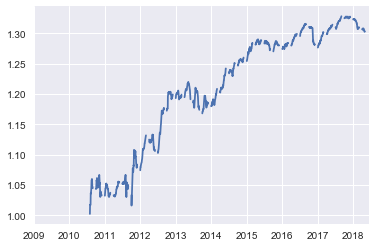

In [22]:
dates=iss_r.index
iss_pos = iss_r.copy() * np.nan
iss_bond_pos=bid.copy() * np.nan
buy_price= ask*np.nan
day_i = iss_r.index[0]
for ii,day_i in enumerate(dates[:-3]):
    if reb_date[ii+1]:
        iss_pos.loc[dates[ii+1],:]=0
        iss_bond_pos.loc[dates[ii+1],:]=0
        order_roa_all=iss_roa.loc[(iss_roa.index<dates[ii+1]) & ((dates[ii+1]-iss_roa.index).days<10)].max(axis=0)
        order_roa_all[iss_cond.loc[dates[ii],:]==False]=np.nan
        num_bonds = int(0.1 * order_roa_all.dropna().shape[0])
        order_roa = order_roa_all.copy().nsmallest(num_bonds)
        for tick in order_roa.index.tolist():
            if any(cond.loc[day_i,binf.loc[binf["iss"]==tick,"isin"]]):
                bond_to_buy=cond.loc[day_i,binf.loc[binf["iss"]==tick,"isin"]].nlargest(1).index
                iss_bond_pos.loc[dates[ii+1],bond_to_buy]=1
                buy_price.loc[dates[ii+1],bond_to_buy]=ask.loc[dates[ii+1],bond_to_buy]
        iss_pos.loc[dates[ii+1],order_roa.index.tolist()] = 1
        

iss_pos = iss_pos.ffill()
iss_bond_pos = iss_bond_pos.ffill()



buy_price=buy_price.ffill()
ba=abs(iss_bond_pos.diff())*(bid/ask-1)

iss_bond_pos[iss_bond_pos==0]=np.nan
iss_pos[iss_pos==0]=np.nan
btr=bid.pct_change()+((1+binf.loc[list(ask),"cpn"]/(buy_price*2)).pow(1/130)-1)   
(iss_bond_pos * (btr+ba/2)).mean(axis=1,skipna=True).add(1).cumprod().plot()#(figsize=[12,9])


